In [1]:
"""
Load packages
"""
import os
import sys
import numpy as np
import re
import glob
from datetime import datetime
from numpy import array, isscalar, uint16, uint32
import pandas as pd
from iminuit import Minuit
from numpy import sqrt 
from scipy.stats import norm
import statistics
import uproot
import types

print("uproot version:", uproot.__version__)

"""
plotting preference
"""
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["font.size"] = 14
#matplotlib.rcParams['figure.figsize'] = [width, height]
plt.rcParams['figure.figsize'] = [15, 8]

"""
Load drop modules

Note: 
    run setup.sh to get environemtal variables: SOURCE_DIR, YAML_DIR, etc
"""
SRC_DIR = os.environ['SOURCE_DIR']
YAML_DIR = os.environ['YAML_DIR']
sys.path.append(SRC_DIR)
from utilities import generate_colormap
from run_drop import RunDROP
from waveform import Waveform
from yaml_reader import YamlReader
from pulse_finder import PulseFinder
from yaml_reader import SAMPLE_TO_NS

def extract_datetime_from_str(s):
    """
    Extract datatime from a str. The datetime must follow the fixed format:
    YYmmddTHHMM
    """
    #print (s)
    #match = re.search(r'\d{6}T\d{4}', s)
    match = re.search('\d{6}T\d{4}', s)

    if match:
        #print (match.group())
        try:
            dt = datetime.strptime(match.group(), '%y%m%dT%H%M')
            #print ("dt" ,dt)
            return dt
        except ValueError:
            print('Fail finding the datetime string from path: %s' % s)
    
class WaveformFitter():
    def __init__(self, raw_data_path, yaml_path='yaml/config.yaml'):
        """
        Constructor. Make a superclass using DROP modules.
        
        Args:
            raw_data_path (str): path to the raw root file
            yaml_path (str): path to the configuration yaml file (default:
                yaml/config.yaml)
        """
        self.cfg = YamlReader(yaml_path) # load yaml config
        self.if_path = raw_data_path
        self.load_run_info()
        self.load_pmt_info()
        #print ('calibration loaded')
        
        # get daq tree via uproot
        #print ("uproot opening")
        f = uproot.open(raw_data_path)
        #print ('getting entry number ', f['daq'].num_entries)
        self.n_entries = f['daq'].num_entries
        #print ('setting waveform')
        self.wfm = Waveform(self.cfg)
        #print ('setting ch names')
        self.wfm.ch_names=self.ch_names
        #print ('setting chn id')
        self.wfm.ch_id = self.ch_id
        #print ('setting nboards')
        self.wfm.n_boards = self.n_boards
        #print ('setting spe mean')
        self.wfm.spe_mean = self.spe_mean
        #print ('dat arrays')
        #for mm in range(500):
        self.daq = f['daq'].arrays()
        #print ('entry id return')
        self.entry_id = 0
        #print ('done')
        
    def load_run_info(self):
        """
        I copied this function from run_drop.py
        """
        f = uproot.open(self.if_path)
        dt = extract_datetime_from_str(self.if_path)
        a = f['run_info'].arrays(['n_boards', 'active_ch_id', 'n_event_proc'], library='np')
        self.n_boards = uint16(a['n_boards'][0])
        self.n_event_proc = uint32(a['n_event_proc'][0])
        tmp = a['active_ch_id'][0]
        if isscalar(tmp): # if only 1 active channels, tmp is a scalar and sort will fail
            tmp = [tmp]
        self.ch_id = sorted(uint16(tmp))
        self.ch_names = ["adc_b%d_ch%d" % (i // 100, i % 100) for i in self.ch_id]
        self.ch_name_to_id_dict = dict(zip(self.ch_names, self.ch_id))
    
    def load_pmt_info(self):
        """
        I copied this function from run_drop.py
        """
        self.spe_mean = {}
        fpath = self.cfg.spe_fit_results_file
        if self.cfg.interpolate_spe:
            dt = extract_datetime_from_str(self.if_path)
            fdir = os.path.dirname(fpath)
            print (fdir)
            led_paths=glob.glob("%s/drop/calib/*.csv" % fdir)
            p0, p1 = None, None
            t0, t1 = 999999, 999999 # arbitary large
            for p in led_paths:
                #print ("extract_datetime_from_str ", extract_datetime_from_str(p))
                if (extract_datetime_from_str(p) == None):
                    continue
                delta = dt-extract_datetime_from_str(p)
                delta_min = delta.total_seconds()/60
                if delta_min>=0:
                    if abs(delta_min)<t0:
                        t0 = abs(delta_min)
                        p0 = p
                else:
                    if abs(delta_min)<t1:
                        t1 = abs(delta_min)
                        p1 = p
            if p1 is None:
                self._set_spe_result(p0)
                #print('Info: using calibration results from', p0)
            else:
                self._set_spe_result(p0)
                df0 = pd.read_csv(p0)
                df1 = pd.read_csv(p1)
                df0.set_index('ch_name', inplace=True)
                df1.set_index('ch_name', inplace=True)
                ch_names = df0.index
                for ch in ch_names:
                    x0 = df0['spe_mean'][ch]
                    x1 = df1['spe_mean'][ch]
                    self.spe_mean[ch] = x0 + (x1-x0)/(t0+t1) * t0
                    # self.spe_fit_results['spe_mean'][ch] = self.spe_mean[ch]
                    self.spe_fit_results.loc[ch, 'spe_mean'] = self.spe_mean[ch]
                print('Info: Intepolate from calibration results', p0, 'and', p1)
        else:
            self._set_spe_result(fpath)
            #print('Info: using calibration results from', fpath)

    def _set_spe_result(self, fpath):
        """
        I copied this function from run_drop.py
        """
        try:
            df = pd.read_csv(fpath)
            df.set_index('ch_name', inplace=True)
            self.spe_fit_results  = df # to be saved in root
            ch_names = df.index
            for ch in ch_names:
                self.spe_mean[ch] = float(df['spe_mean'][ch])
        except:
            sys.exit("your spe_fit_results_file cannot be loaded properly!")
        
    def process_one(self, i):    
        """
        Different name. Similar to a function in run_drop.py. Given an entry index, process that entry.
        """
        self.event_id = self.daq[i].event_id
        self.event_ttt = self.daq[i].event_ttt
        self.wfm.reset()
        self.wfm.set_raw_data(self.daq[i])
        self.wfm.find_saturation()
        self.wfm.subtract_flat_baseline()
            #wfm.find_ma_baseline()
        self.wfm.do_spe_normalization()
        self.wfm.define_trigger_position()
        self.wfm.correct_daisy_chain_trg_delay()
        self.wfm.sum_channels()
        self.wfm.define_time_axis()
        self.wfm.integrate_waveform()
        self.wfm.calc_roi_info()
        self.wfm.calc_aux_ch_info()

    def process_next(self):
        """
        Put process one in a loop
        """
        if self.entry_id<self.n_entries:
            i = self.entry_id
            self.process_one(i)
            self.entry_id+=1
            return True
        else:
            return False
            
    def get_wfm_data(self, t_min=370, t_max=470, ch_name='sum_bot'):
        """
        Arg:
            t_min: float
            t_max: float
            ch_name: channel names identical to how it's defined in DROP. 
        Options: sum_bot, sum_side, sum_row1,..., sum_row4, ..., sum_col1,..., sum_col4. 
        Individual channels are accessible too. For example, adc_b1_ch3 is board 1 channel 3.
        """
        t = self.wfm.time_axis_ns
        mask = (t>=t_min) & (t<t_max)
        x_data=t[mask]
        #y_data=wf.wfm.amp_pe[ch_name][mask]
        y_data=self.wfm.amp_pe[ch_name][mask]
        return x_data, y_data
    
    def get_wfm_data_mv(self, t_min=370, t_max=470, ch_name='sum_bot'):
        """
        Arg:
            t_min: float
            t_max: float
            ch_name: channel names identical to how it's defined in DROP. 
        Options: sum_bot, sum_side, sum_row1,..., sum_row4, ..., sum_col1,..., sum_col4. 
        Individual channels are accessible too. For example, adc_b1_ch3 is board 1 channel 3.
        """
        t = self.wfm.time_axis_ns
        #mask = (t>=t_min) & (t<t_max)
        #x_data=t[mask]
        x_data=t
        y_data=self.wfm.amp_mV[ch_name]
        #y_data=self.wfm.amp_mV[ch_name][mask]

        return x_data, y_data
    
    def get_aux_ch_mV(self, ch_name='adc_b1_ch0'):
        return self.wfm.aux_ch_area_mV[ch_name]

uproot version: 5.0.8


In [2]:
"""
Example: usage of WaveformFitter class (feel free to change the class name since 
there is no fitting method currently implemented).
"""

event_start_time=-1
event_end_time=-1
# define path to your raw root file
DATA_DIR='/home/guang/work/bnl1t/drop/src'
ch_string = ""

for i in range(15):
    ch_string += "adc_b1_ch{} ".format(i+1)
for i in range(15):
    ch_string += "adc_b2_ch{} ".format(i)
for i in range(16):
    ch_string += "adc_b3_ch{} ".format(i)
for i in range(12):
    ch_string += "adc_b4_ch{} ".format(i)
    
#print (ch_string)    

#for word in ch_string.split():
#    print (word)
    
def display_charge(chg):
    dis_x=[]
    dis_y=[]
    area=[]
    area2=[]
    locx_bot = [381, 381, 381, 381, 
            190.5, 190.5, 190.5, 190.5, 190.5, 190.5, 190.5, 
            0, 0, 0, 0, 0, 0, 0, 0, 
           -190.5, -190.5, -190.5, -190.5, -190.5, -190.5, -190.5,
           -381, -381, -381, -381]
    locy_bot = [-171.45, -57.15, 57.15, 171.45,
           -342.9, -228.6, -114.3, 0, 114.3, 228.6, 342.9,
           -400.05, -285.75, -171.45, -57.15,57.15, 171.45, 285.75, 400.05,
           -342.9, -228.6, -114.3, 0, 114.3, 228.6, 342.9,
           -171.45, -57.15, 57.15, 171.45]
    locx_side= [-532.955, -532.955,-532.955,-532.955,
               532.955,532.955,532.955,532.955,
               0,0,0,0,0,0,0,0,]
    locy_side= [0,0,0,0,0,0,0,0,
               -532.955, -532.955,-532.955,-532.955,
               532.955,532.955,532.955,532.955]
    locz_side= [-495.3, -336.55, 222.25, 393.7,
               -495.3, -336.55, 222.25, 393.7,
               -495.3, -336.55, 222.25, 393.7,
               -495.3, -336.55, 222.25, 393.7]
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.rcParams['figure.figsize'] = [10, 4]
    for i in range(len(chg)):
        if i < 30:
            area.append(chg[i]*50)
        elif i < 46:
            if i>29 and i<34:
                dis_x.append(0)
            if i>33 and i<38:
                dis_x.append(180)
            if i>37 and i<42:
                dis_x.append(90)
            if i>41 and i<46:
                dis_x.append(270)
            dis_y.append(locz_side[i-30])
            area2.append(chg[i-30]*50)
    ax1.scatter(locx_bot, locy_bot, s=area, c="Blue", alpha=1, label="Bottom plane")
    ax2.scatter(dis_x, dis_y, s=area2, c="Blue", alpha=1, label="Barrel plane")
    ax1.set_xlabel("X (mm)")
    ax1.set_ylabel("Y (mm)")
    ax2.set_xlabel("$\phi$ (deg.) with R = 533 mm")
    ax2.set_ylabel("Z (mm)")
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    plt.show()

In [15]:
from scipy.optimize import curve_fit
#from lmfit.models import GaussianModel
from lmfit import Model
tmin = 350
tmax = 430

class processor():
    def __init__(self):
        print("processor ready")

    def process_data(self, dtime, nevts, nruns, exa):

        tmin = 220
        tmax = 320
        tt = []
        tt_mv1 = []

        for ie in range(nruns):

            data_path='/media/gyang/4tb2020/bnl1t/drop/src/phase2_wbls_1pct_muon_mid_x64_19mV_alpha_2023_{:s}_{:d}.root'.format(dtime, ie)
            wf = WaveformFitter(data_path, '/home/gyang/work/bnl1t/drop/yaml/config_guang.yaml')
 
            for ii in range(nevts):
                
                # process the first entry
                #print ('processing one event')
                wf.process_one(ii)
                event_id=wf.event_id
                event_ttt=wf.event_ttt
                #print('run_id:', run_id, "event_id:", event_id, "event_ttt:", event_ttt)

                evt_chg=[]
                chn_count = 0
                # get the data between t_min and t_max. 
                for ich in ch_string.split():
                    if chn_count>45: 
                        break
                    if "adc" in ich:
                        chn_count += 1
                        x_data, y_data = wf.get_wfm_data(t_min=0, t_max=2000, ch_name='{}'.format(ich))
                    else:
                        print ("can't do this channel")

                    yy_data = y_data.tolist()
                    aa = yy_data.index(np.max(yy_data))

                    tmin = x_data[aa] - 20
                    tmax = x_data[aa] + 40

                    if np.max(y_data) > -1e9:
                        if "adc" in ich:
                            x_data_mv, y_data_mv = wf.get_wfm_data(t_min=tmin, t_max=tmax, ch_name='{}'.format(ich))
                        else:
                            print ("can't do this channel")
                        summ_mv = 0
                        for idata in range(len(y_data_mv)):
                            summ_mv += y_data_mv[idata]*2  
                        evt_chg.append(summ_mv)
                        if exa and chn_count<10: 
                            plt.subplot(3,3,chn_count)
                            plt.plot(x_data_mv, y_data_mv, color='k', label='channel %s'%ich)
                    if exa:
                        plt.legend()
                        
                if (wf.get_aux_ch_mV(ch_name='adc_b1_ch0') +wf.get_aux_ch_mV(ch_name='adc_b2_ch15')>300 ):
                    print ("this is a crossing muon.")
                else:
                    print ("this is not a crossing muon.")
                            
                display_charge(evt_chg)

            del wf

        back_array = []
        return back_array
            

doing day with event number  0625   10
processor ready
this is not a crossing muon.


/home/gyang/.local/lib/python3.8/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


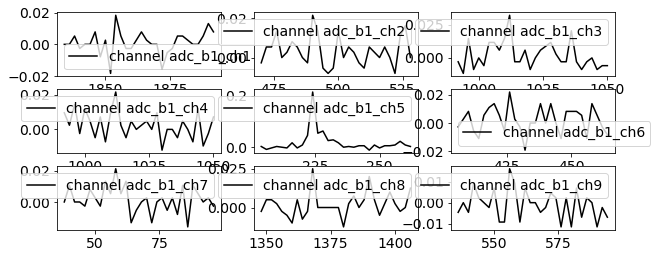

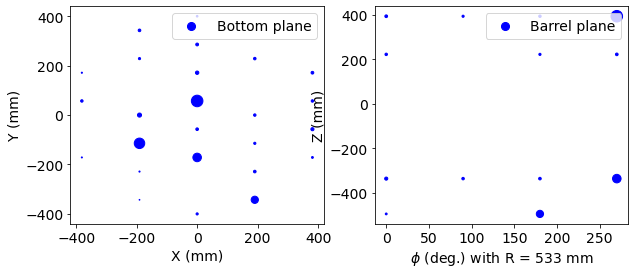

this is not a crossing muon.


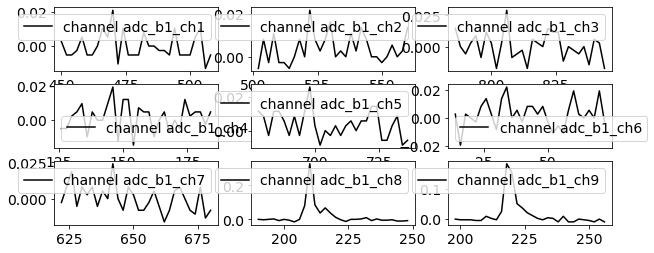

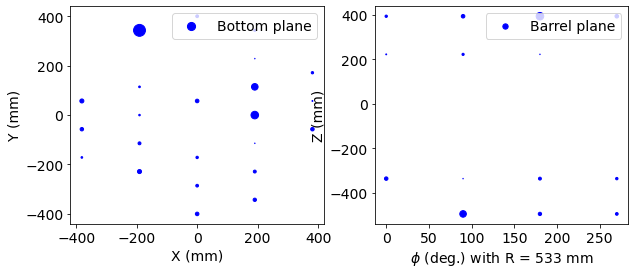

this is not a crossing muon.


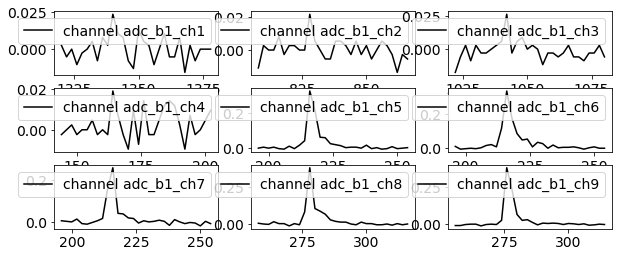

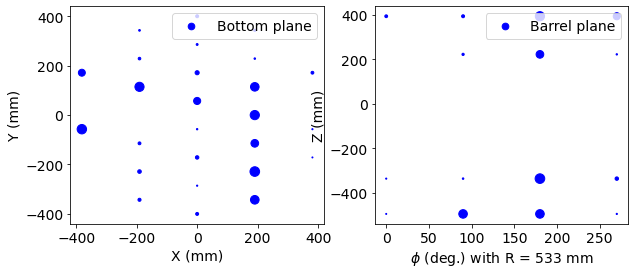

this is not a crossing muon.


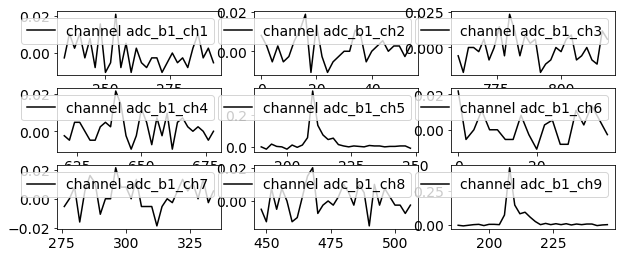

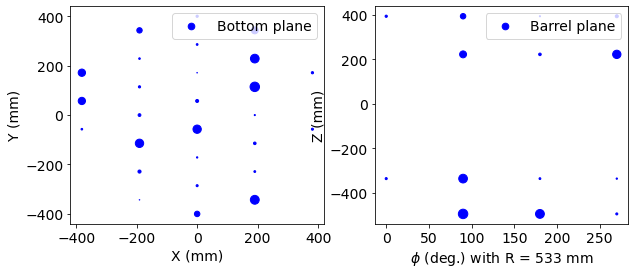

this is not a crossing muon.


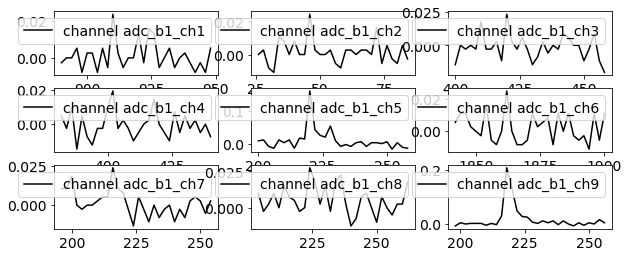

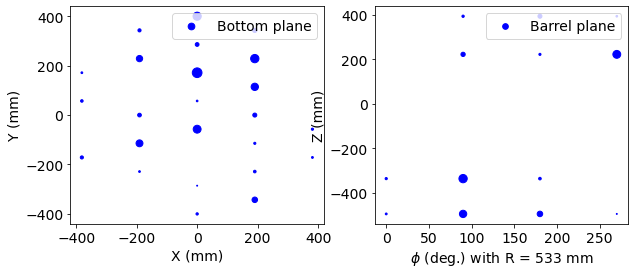

this is not a crossing muon.


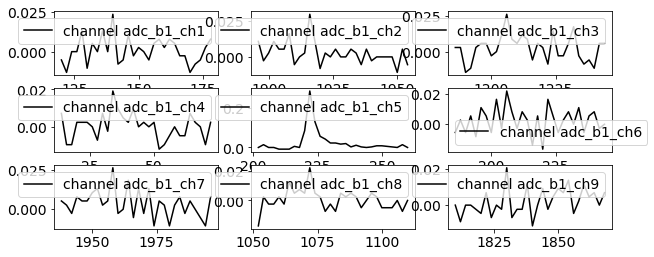

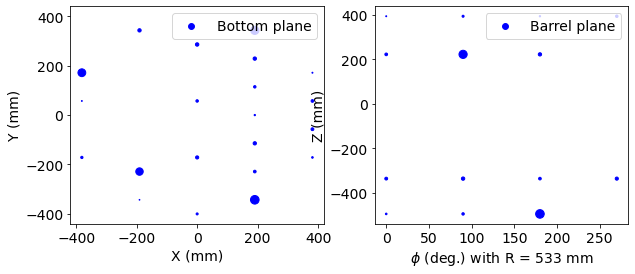

this is not a crossing muon.


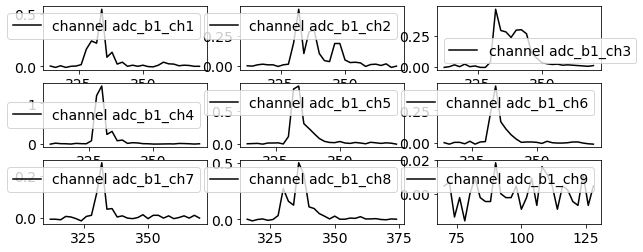

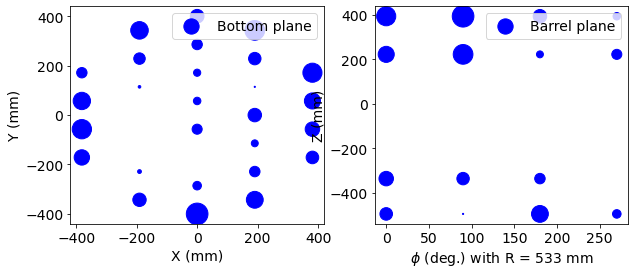

this is not a crossing muon.


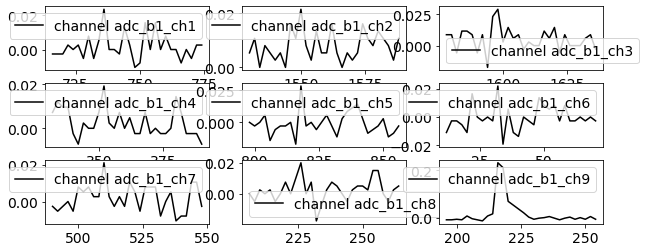

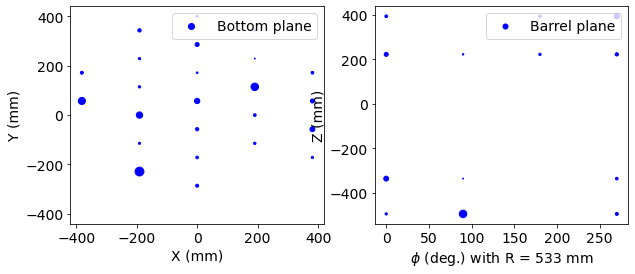

this is not a crossing muon.


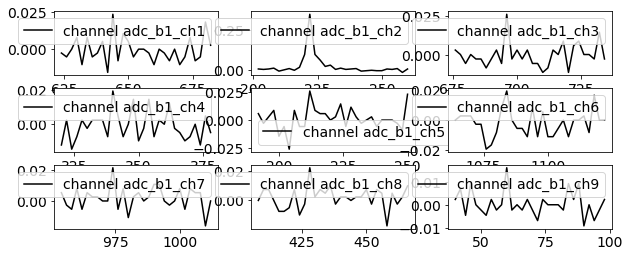

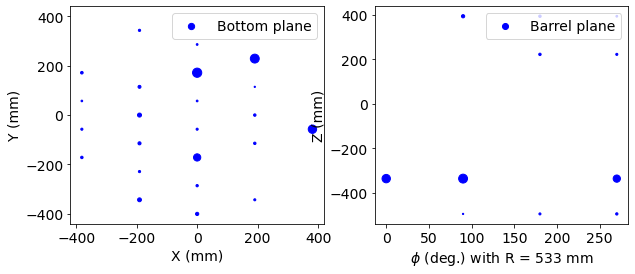

this is not a crossing muon.


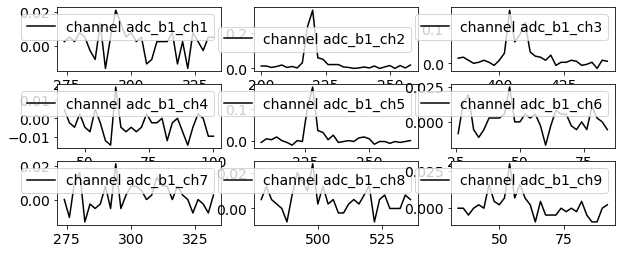

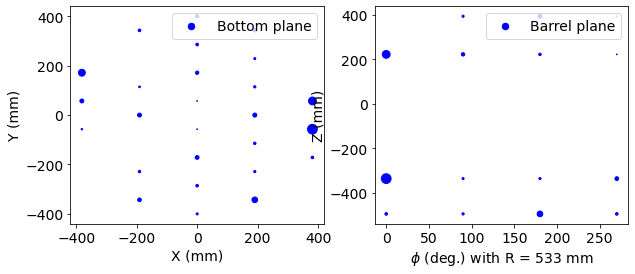

In [16]:
all_date = "0625 "
nevt =10
show_example=False
for dtime in all_date.split():
    print ("doing day with event number ", dtime,' ',nevt)
    pr = processor()
    # arguments: date of the day, number of events, number of runs - should be 1, if want to show waveform examples
    result = pr.process_data(dtime, nevt, 1, show_example)
